In [9]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import cartopy
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake
# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
col_url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(col_url)

In [2]:
pd.set_option('display.max_rows', 250)

In [34]:
cat = col.search(experiment_id=['ssp585'],#,'historical'],  # pick the `historical` forcing experiment
                 table_id='day',             # choose to look at atmospheric variables (A) saved at monthly resolution (mon)
                 variable_id='mrro') 

In [35]:
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,ScenarioMIP,BCC,BCC-CSM2-MR,ssp585,r1i1p1f1,day,mrro,gn,gs://cmip6/ScenarioMIP/BCC/BCC-CSM2-MR/ssp585/...,NaN
1,ScenarioMIP,CCCma,CanESM5,ssp585,r10i1p1f1,day,mrro,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp585/r1...,NaN
2,ScenarioMIP,CCCma,CanESM5,ssp585,r10i1p2f1,day,mrro,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp585/r1...,NaN
3,ScenarioMIP,CCCma,CanESM5,ssp585,r11i1p1f1,day,mrro,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp585/r1...,NaN
4,ScenarioMIP,CCCma,CanESM5,ssp585,r11i1p2f1,day,mrro,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp585/r1...,NaN
5,ScenarioMIP,CCCma,CanESM5,ssp585,r12i1p1f1,day,mrro,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp585/r1...,NaN
6,ScenarioMIP,CCCma,CanESM5,ssp585,r12i1p2f1,day,mrro,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp585/r1...,NaN
7,ScenarioMIP,CCCma,CanESM5,ssp585,r13i1p1f1,day,mrro,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp585/r1...,NaN
8,ScenarioMIP,CCCma,CanESM5,ssp585,r13i1p2f1,day,mrro,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp585/r1...,NaN
9,ScenarioMIP,CCCma,CanESM5,ssp585,r14i1p1f1,day,mrro,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp585/r1...,NaN


In [26]:
time_slice = slice('1850','2099')

In [28]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False})

ds_dict = {}
gmst_dict = {}
for name, ds in tqdm(dset_dict.items()):
    # rename spatial dimensions if necessary
    if ('longitude' in ds.dims) and ('latitude' in ds.dims):
        ds = ds.rename({'longitude':'lon', 'latitude': 'lat'}) # some models labelled dimensions differently...
        
    ds = xr.decode_cf(ds) # temporary hack, not sure why I need this but has to do with calendar-aware metadata on the time variable
    ds = ds.sel(time=time_slice) # subset the data for the time period of interest
    
    # drop redundant variables (like "height: 2m")
    for coord in ds.coords:
        if coord not in ['lat','lon','time']:
            ds = ds.drop(coord)

    ## Calculate global-mean surface temperature (GMST)
    cos_lat_2d = np.cos(np.deg2rad(ds['lat'])) * xr.ones_like(ds['lon']) # effective area weights
    gmst = (
        (ds['snw'] * cos_lat_2d).sum(dim=['lat','lon']) /
        cos_lat_2d.sum(dim=['lat','lon'])
    )
    
    # Add GMST to dictionary
    gmst_dict[name] = gmst.squeeze()
    
    # Add near-surface air temperature to dictionary
    ds_dict[name] = ds

Progress: |-------------------------------------------------------------------------------| 0.0% 
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 5 group(s)


/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [30]:
ds_dict

{'ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp585.day.gr': <xarray.Dataset>
 Dimensions:  (lat: 143, lon: 144, member_id: 1, time: 31046)
 Coordinates:
   * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
   * time     (time) datetime64[ns] 2015-01-01T12:00:00 ... 2099-12-31T12:00:00
   * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
 Dimensions without coordinates: member_id
 Data variables:
     snw      (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 4365, 143, 144), meta=np.ndarray>
 Attributes:
     CMIP6_CV_version:       cv=6.2.3.5-2-g63b123e
     Conventions:            CF-1.7 CMIP-6.2
     EXPID:                  ssp585
     activity_id:            ScenarioMIP
     branch_method:          standard
     branch_time_in_child:   0.0
     branch_time_in_parent:  60265.0
     contact:                ipsl-cmip6@listes.ipsl.fr
     creation_date:          2018-12-18T20:56:09Z
     data_specs_version:     01.00.28
     descriptio

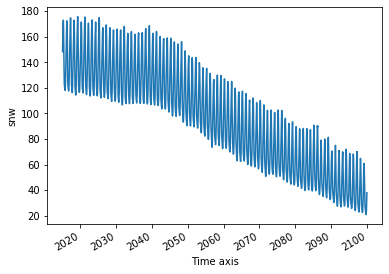

In [31]:
ds_dict['ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp585.day.gr'].snw.mean(dim=['lat','lon']).plot()

In [ ]:
import cartopy.crs as ccrs
ortho = ccrs.Orthographic(-90, 20) # define target coordinate frame
geo = ccrs.PlateCarree() # define origin coordinate frame

plt.figure(figsize=(9,7))
ax = plt.subplot(1, 1, 1, projection=ortho)

q = temperature_change.plot(ax=ax, transform = geo) # plot a colormap in transformed coordinates

ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
plt.title('Patterns of global warming over the Americas',fontsize=16, ha='center');
plt.savefig('../figures/historical_warming_patterns.png',dpi=100,bbox_inches='tight')